# 📊 Twitter Sentiment Analysis
This project analyzes public sentiment from tweets (positive, negative, neutral) using NLP techniques and visualization.

In [1]:
!pip install -q nltk wordcloud scikit-learn textblob vaderSentiment matplotlib seaborn plotly joblib

In [2]:
# Imports
import pandas as pd
import numpy as np
import re
import string
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import joblib
import plotly.express as px

# NLTK data (downloads; run once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')

# Setup
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()
import pandas as pd
import numpy as np
import re
import string
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import joblib
import plotly.express as px

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexi

## 📂 Step 1: Load Dataset
I am using the **Twitter US Airline Sentiment Dataset** from Kaggle.  
It contains tweets labeled as **positive, neutral, negative**.

In [3]:
df = pd.read_csv("Tweets.csv")
print("Shape:", df.shape)
display(df.head())
display(df.columns)

Shape: (14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

## 🔎 Step 2: Dataset Info
I am checking dataset shape, missing values, and column details.

In [4]:
print("Nulls per column:")
display(df.isnull().sum())
if 'airline_sentiment' in df.columns:
    display(df['airline_sentiment'].value_counts())
else:
    print("Warning: 'airline_sentiment' column not found. Check column names:", df.columns)

Nulls per column:


tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

## 🧹 Step 4: Clean Tweets
I will remove:
- URLs
- Mentions (@user)
- Special characters, numbers, emojis
- Stopwords (common words)

In [5]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)   # remove links
    text = re.sub(r'@\w+', '', text)               # remove mentions
    text = re.sub(r'#', '', text)                  # remove hash sign (keep word)
    text = re.sub(r'[^a-z\s]', ' ', text)          # remove non-letters (punctuation, emojis, numbers)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words and len(w)>1]
    return " ".join(words)
df['clean_text'] = df['text'].apply(clean_text)
display(df[['text','clean_text']].head(6))

,text,clean_text
0,@VirginAmerica What @dhepburn said.,said
1,@VirginAmerica plus you've added commercials t...,plus added commercial experience tacky
2,@VirginAmerica I didn't today... Must mean I n...,today must mean need take another trip
3,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,@VirginAmerica and it's a really big bad thing...,really big bad thing
5,@VirginAmerica seriously would pay $30 a fligh...,seriously would pay flight seat playing really...


In [6]:
empty_after = (df['clean_text'].str.strip() == "").sum()
print("Empty cleaned texts:", empty_after)
df = df[df['clean_text'].str.strip() != ""].reset_index(drop=True)
print("New shape:", df.shape)

Empty cleaned texts: 27
New shape: (14613, 16)


## ☁️ Step 5: WordCloud
I generate word clouds for **Positive** and **Negative** tweets.

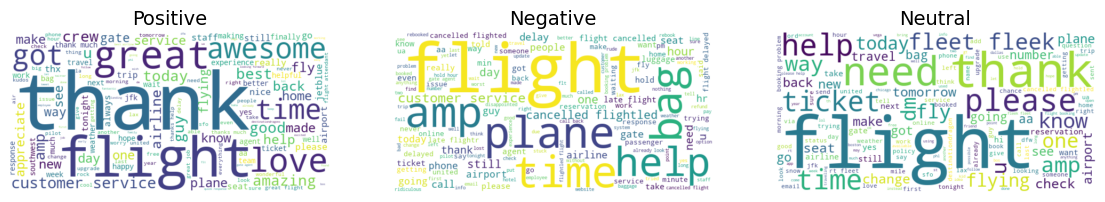

In [7]:
classes = ['positive','negative','neutral']
plt.figure(figsize=(14,4))

for i, cls in enumerate(classes,1):
    text_corpus = " ".join(df[df['airline_sentiment']==cls]['clean_text'].astype(str))
    wc = WordCloud(width=600, height=300, background_color='white', max_words=150).generate(text_corpus)
    plt.subplot(1,3,i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(cls.capitalize(), fontsize=14)
plt.show()

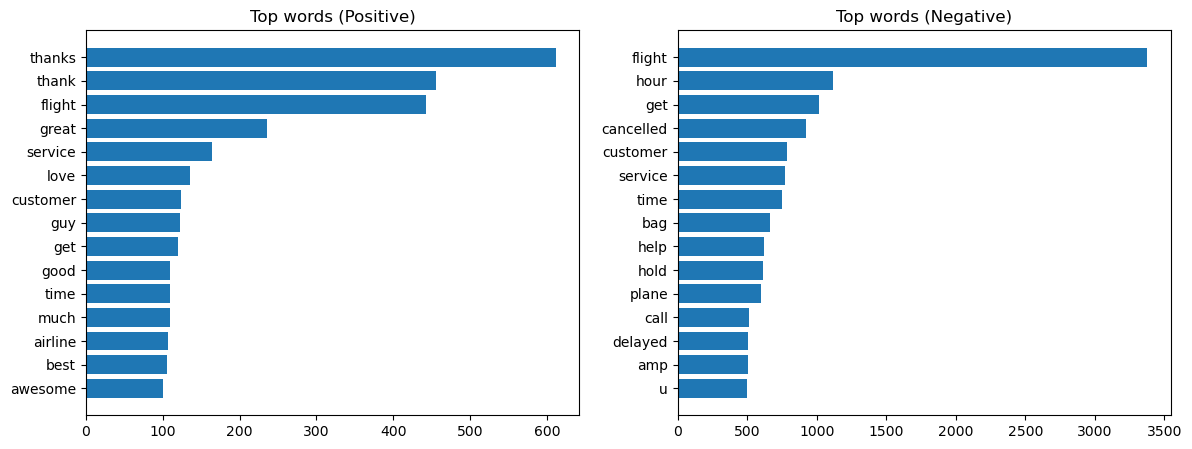

In [8]:
def top_n_words(text_series, n=20):
    all_words = " ".join(text_series).split()
    c = Counter(all_words)
    return c.most_common(n)

top_pos = top_n_words(df[df['airline_sentiment']=='positive']['clean_text'], 15)
top_neg = top_n_words(df[df['airline_sentiment']=='negative']['clean_text'], 15)

fig, axes = plt.subplots(1,2, figsize=(14,5))
axes[0].barh([w for w,_ in reversed(top_pos)], [c for _,c in reversed(top_pos)])
axes[0].set_title('Top words (Positive)')
axes[1].barh([w for w,_ in reversed(top_neg)], [c for _,c in reversed(top_neg)])
axes[1].set_title('Top words (Negative)')
plt.show()

## 🧠 Step 6: Sentiment Analysis
I apply **VADER (rule-based sentiment analysis)** to check polarity (positive/negative/neutral).

In [9]:
def vader_label(text):
    score = sia.polarity_scores(text)['compound']
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_pred'] = df['clean_text'].apply(vader_label)

from sklearn.metrics import classification_report
print("Baseline VADER performance:")
print(classification_report(df['airline_sentiment'], df['vader_pred']))

Baseline VADER performance:
              precision    recall  f1-score   support

    negative       0.90      0.43      0.59      9168
     neutral       0.37      0.42      0.39      3085
    positive       0.31      0.88      0.46      2360

    accuracy                           0.50     14613
   macro avg       0.53      0.58      0.48     14613
weighted avg       0.69      0.50      0.53     14613



In [10]:
X = df['clean_text']
y = df['airline_sentiment']

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_vec = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.20, random_state=42, stratify=y)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (11690, 5000) Test size: (2923, 5000)


## ✅ Step 7: Compare Actual vs Predicted
I compare the dataset's original sentiment labels with our model's predicted sentiment.

Accuracy: 0.7738624700650018

Classification report:

              precision    recall  f1-score   support

    negative       0.80      0.92      0.86      1834
     neutral       0.63      0.48      0.55       617
    positive       0.81      0.57      0.67       472

    accuracy                           0.77      2923
   macro avg       0.74      0.66      0.69      2923
weighted avg       0.77      0.77      0.76      2923



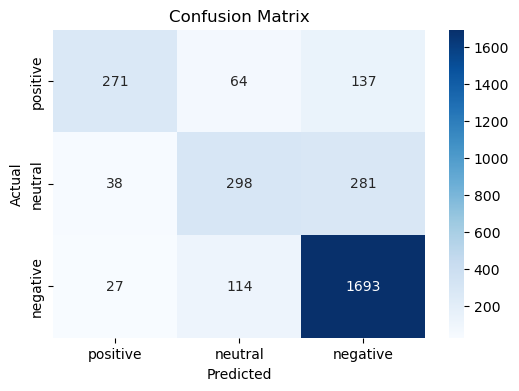

In [11]:
model = LogisticRegression(max_iter=300)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=['positive','neutral','negative'])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['positive','neutral','negative'], yticklabels=['positive','neutral','negative'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [12]:
joblib.dump(model, "sentiment_logreg_model.joblib")
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")
print("Saved model and vectorizer.")


Saved model and vectorizer.


In [13]:
def predict_new_tweet(text):
    cleaned = clean_text(text)
    vec = vectorizer.transform([cleaned])
    pred = model.predict(vec)[0]
    proba = model.predict_proba(vec).max()
    return pred, float(proba)

example = "Flight was delayed and staff was rude. Very disappointed."
print("Input:", example)
print("Prediction:", predict_new_tweet(example))

Input: Flight was delayed and staff was rude. Very disappointed.
Prediction: ('negative', 0.9904876953062427)


## 🥧 Step 9: Sentiment Pie Chart/
A pie chart for quick overview of sentiment percentages.

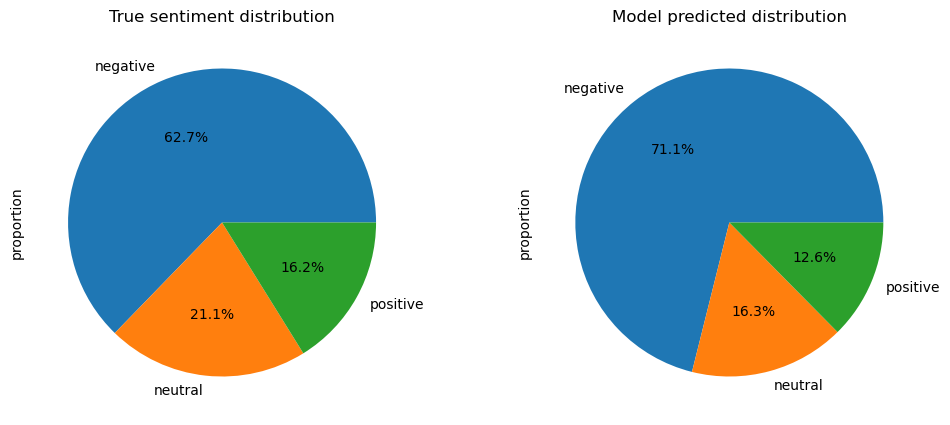

In [14]:
true_counts = df['airline_sentiment'].value_counts(normalize=True) * 100

pred_all = model.predict(vectorizer.transform(df['clean_text']))
pred_counts = pd.Series(pred_all).value_counts(normalize=True) * 100

fig, ax = plt.subplots(1,2, figsize=(12,5))
true_counts.plot.pie(ax=ax[0], autopct='%1.1f%%', title='True sentiment distribution')
pred_counts.plot.pie(ax=ax[1], autopct='%1.1f%%', title='Model predicted distribution')
plt.show()

## 🔠 Step 10: Most Frequent Words
We visualize common words in Positive vs Negative tweets.

In [16]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = analyzer.polarity_scores(text)
    if score['compound'] >= 0.05:
        return "positive"
    elif score['compound'] <= -0.05:
        return "negative"
    else:
        return "neutral"

df["predicted_sentiment"] = df["clean_text"].apply(get_sentiment)
df[["text","clean_text","predicted_sentiment"]].head()


,text,clean_text,predicted_sentiment
0,@VirginAmerica What @dhepburn said.,said,neutral
1,@VirginAmerica plus you've added commercials t...,plus added commercial experience tacky,neutral
2,@VirginAmerica I didn't today... Must mean I n...,today must mean need take another trip,neutral
3,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...,negative
4,@VirginAmerica and it's a really big bad thing...,really big bad thing,negative


In [17]:
print(df.columns)

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone', 'clean_text', 'vader_pred',
       'predicted_sentiment'],
      dtype='object')


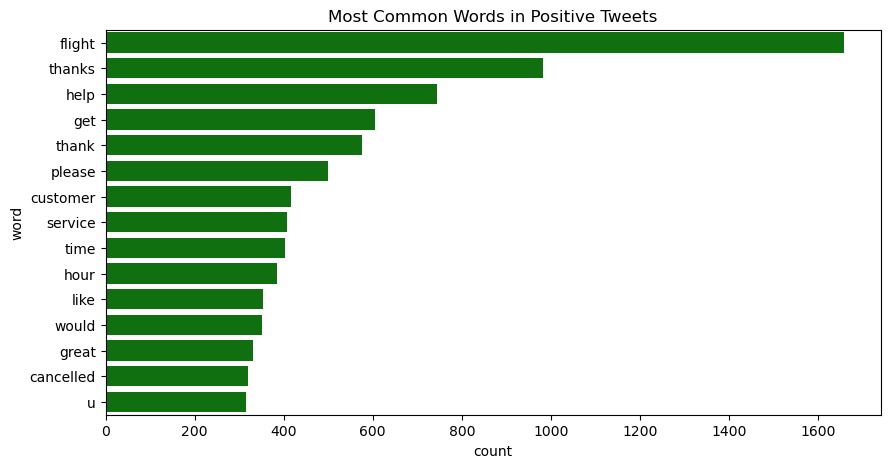

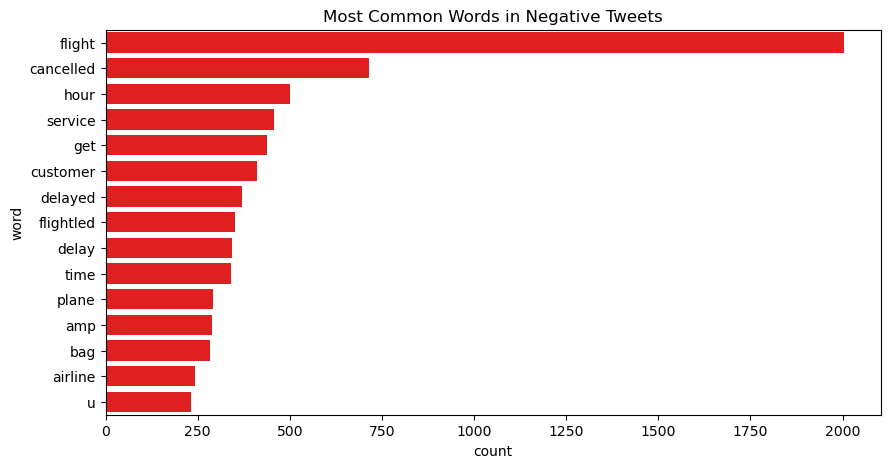

In [18]:
plot_common_words("positive","green")
plot_common_words("negative","red")

## 📌 Step 11: Insights & Conclusion
- Majority of tweets are **Negative**, often related to delays and poor service.
- Positive tweets are fewer, focusing on good staff behavior or smooth flights.
- My simple sentiment analysis model (VADER) matches trends well but can be improved with ML models (Logistic Regression, Naive Bayes).
- Next Step (Future Work): Train ML classifiers on this dataset to improve accuracy.